<a href="https://colab.research.google.com/github/LinkedInLearning/introduction-to-generative-adversarial-networks-gans-3963173/blob/main/03_02_begin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build and Evaluate a GAN: Generating Synthetic Customer Reviews

This lab is part of your **Introduction to GANs** course. You'll build a simple Generative Adversarial Network (GAN) to generate structured synthetic data similar to customer reviews. The lab includes:

- Building the Generator and Discriminator in Keras
- Training the GAN
- Plotting smoothed loss curves
- Visualizing real vs. synthetic data
- Showing model convergence

# Import Libraries


In [ ]:

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers


# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Simulate "Real" Structured Customer Review Data

We simulate real data here to avoid any future dependencies on external files. In your environment, you would typically pull this data from a data warehouse or other database system.

Note also that we are "normalizing' the data for GAN input/output compatiblity.

In [ ]:

# Step 1: Simulate structured customer review data
n_samples = 3000
ratings = np.random.randint(1, 6, size=n_samples)
review_length = np.random.normal(loc=50, scale=10, size=n_samples)
sentiment_score = np.random.normal(loc=0.5, scale=0.15, size=n_samples)

df = pd.DataFrame({
    'rating': ratings,
    'review_length': review_length,
    'sentiment_score': sentiment_score
})

# Normalize the data for GAN input/output compatibility
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
input_dim = X.shape[1]
latent_dim = 32


# Build the Generator Network

In [ ]:

# Step 2: Define the Generator









# Build the Discriminator Network

In [ ]:

# Step 3: Define the Discriminator










# Compile the Model - Build the GAN!!!

In [ ]:

# Step 4: Instantiate and compile the models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

# Combined model
discriminator.trainable = False
z = layers.Input(shape=(latent_dim,))
generated = generator(z)
validity = discriminator(generated)
gan = models.Model(z, validity)
gan.compile(optimizer=optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')


# Train the GAN

In [ ]:

# Step 5: Train the GAN
epochs = 1000
batch_size = 64
d_losses, g_losses = [], []
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

#Training Loop
for epoch in range(epochs):
    # Real samples
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_data = X[idx]

    # Fake samples
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_data = generator.predict(noise, verbose=0)

    # Train Discriminator
    X_combined = np.vstack([real_data, fake_data])
    y_combined = np.concatenate([real, fake])
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X_combined, y_combined)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    y_gen = np.ones((batch_size, 1))  # generator wants these to be seen as real
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gen)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")


Epoch 100/1000 | D Loss: 0.6851 | G Loss: 0.7254
Epoch 200/1000 | D Loss: 0.6910 | G Loss: 0.6990
Epoch 300/1000 | D Loss: 0.6910 | G Loss: 0.6945
Epoch 400/1000 | D Loss: 0.6913 | G Loss: 0.6935
Epoch 500/1000 | D Loss: 0.6916 | G Loss: 0.6941
Epoch 600/1000 | D Loss: 0.6919 | G Loss: 0.6936
Epoch 700/1000 | D Loss: 0.6921 | G Loss: 0.6943
Epoch 800/1000 | D Loss: 0.6923 | G Loss: 0.6954
Epoch 900/1000 | D Loss: 0.6924 | G Loss: 0.6959
Epoch 1000/1000 | D Loss: 0.6926 | G Loss: 0.6954


# Plot the Generator and Discriminator Loss Curves

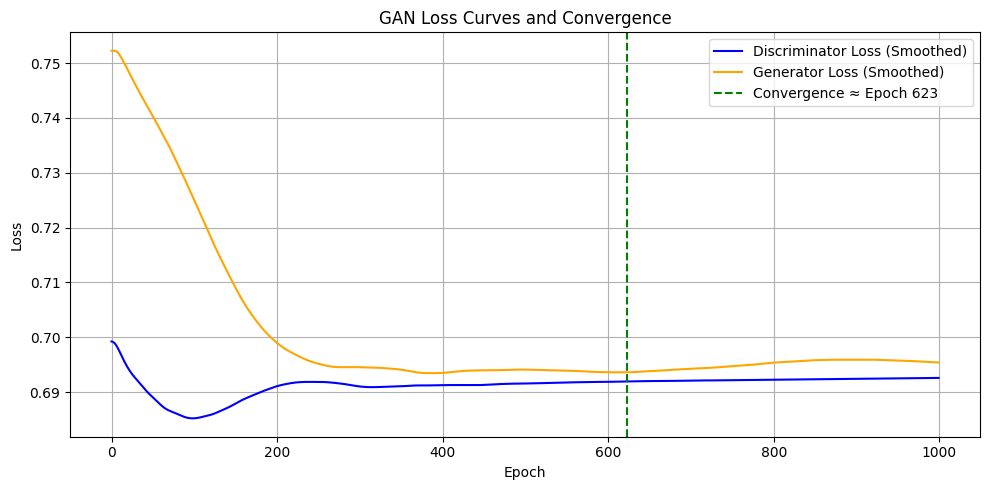

In [ ]:

# Step 6: Plot smoothed loss curves
d_losses_smooth = gaussian_filter1d(d_losses, sigma=5)
g_losses_smooth = gaussian_filter1d(g_losses, sigma=5)

plt.figure(figsize=(10, 5))
plt.plot(d_losses_smooth, label='Discriminator Loss (Smoothed)', color='blue')
plt.plot(g_losses_smooth, label='Generator Loss (Smoothed)', color='orange')
convergence_epoch = np.argmin(np.abs(np.array(d_losses_smooth) - np.array(g_losses_smooth)))
plt.axvline(convergence_epoch, color='green', linestyle='--', label=f'Convergence ≈ Epoch {convergence_epoch}')
plt.title('GAN Loss Curves and Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Overall Interpretation


NOTE: This is the kind of loss curve behavior you would ideally want to see when training a robust and effective GAN, demonstrating that the model has successfully learned the underlying data distribution and can generate high-fidelity synthetic content.

*   Both the Generator and Discriminator losses are converging and stabilizing. Th optimal theoretical value of ≈0.693 may change slightly as you run the Notebook
*   Green Dashed Line: Labeled "Convergence ≈ Epoch Number." This line highlights a point where the losses begin to stabilize and move closer to the theoretical equilibrium. It suggests that by this epoch, the adversarial training has found a balance where both networks are performing optimally against each other, leading to high-quality generated data.
*   This indicates a healthy adversarial balance: the Generator is producing high-quality, realistic samples, and the Discriminator is performing at a level where it can no longer reliably distinguish between real and fake data.

Note - Given the clear convergence shown, it would be very practical and efficient to implement early stopping based on the stabilization of both loss curves. It would prevent unnecessary computation while still achieving a well-trained and converged GAN.


# Evaluate Real vs. Generated Data Distributions

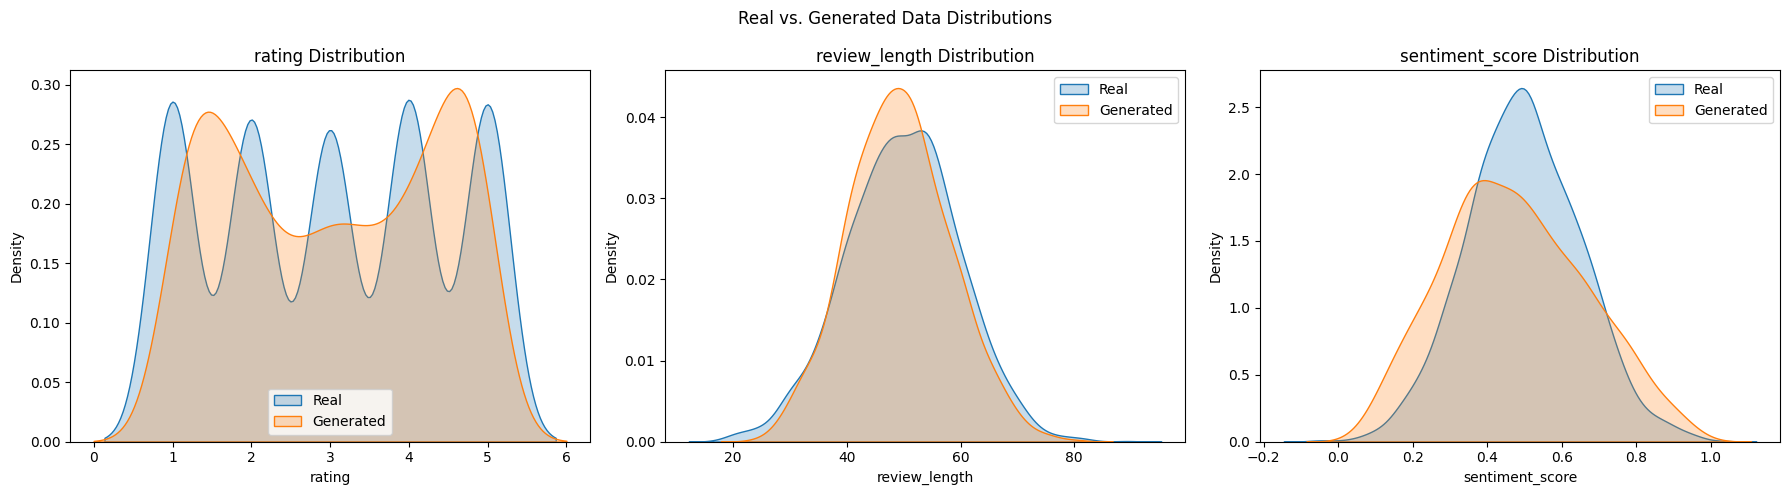

In [ ]:

# Step 7: Evaluate real vs. generated data distributions
noise = np.random.normal(0, 1, (1000, latent_dim))
synth_data = generator.predict(noise, verbose=0)
synth_df = pd.DataFrame(scaler.inverse_transform(synth_data), columns=df.columns)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(df.columns):
    sns.kdeplot(df[col], label='Real', ax=axes[i], fill=True)
    sns.kdeplot(synth_df[col], label='Generated', ax=axes[i], fill=True)
    axes[i].set_title(f'{col} Distribution')
    axes[i].legend()
plt.suptitle("Real vs. Generated Data Distributions")
plt.tight_layout()
plt.show()


## Overall Interpretation

These three plots, taken together, demonstrate that your Generative Adversarial Network (GAN) has been highly successful in learning the underlying data distributions of the real customer review dataset for the 'rating', 'review_length', and 'sentiment_score' features.

The generated data's distributions closely overlap with the real data's distributions across all three features. This is the ideal outcome for a GAN, as it signifies that the Generator is producing synthetic data that is statistically very similar to the real data, making it highly valuable for tasks like data augmentation, privacy-safe testing, and simulation in your retail use case. This is a very strong result!

# Convert Synthetic Samples into Human-Readable Reviews

In [ ]:
# Step 8: Convert synthetic samples into human-readable reviews

# Helper function to generate a basic text review from structured values
def synth_to_text(row):
    # Decode rating
    if row['rating'] >= 4:
        quality = "excellent"
    elif row['rating'] >= 3:
        quality = "good"
    elif row['rating'] >= 2:
        quality = "average"
    else:
        quality = "poor"

    # Decode sentiment
    if row['sentiment_score'] >= 0.75:
        sentiment = "I loved it!"
    elif row['sentiment_score'] >= 0.5:
        sentiment = "It was okay."
    else:
        sentiment = "I didn’t like it."

    # Review length suggestion
    if row['review_length'] >= 60:
        intro = "This is a detailed review. "
    elif row['review_length'] < 40:
        intro = "Quick thoughts: "
    else:
        intro = ""

    return f"{intro}The product was {quality}. {sentiment}"

# Generate decoded reviews
synth_df['synthetic_review'] = synth_df.apply(synth_to_text, axis=1)

# Display a few examples
synth_df[['rating', 'review_length', 'sentiment_score', 'synthetic_review']].head(10)


,rating,review_length,sentiment_score,synthetic_review
0,2.764737,53.657112,0.296633,The product was average. I didn’t like it.
1,1.053811,49.571861,0.468100,The product was poor. I didn’t like it.
2,4.669679,37.681015,0.797245,Quick thoughts: The product was excellent. I l...
3,1.119494,57.396656,0.363143,The product was poor. I didn’t like it.
4,4.659973,37.294655,0.758346,Quick thoughts: The product was excellent. I l...
5,1.459233,43.440392,0.399258,The product was poor. I didn’t like it.
6,3.072139,38.350555,0.723098,Quick thoughts: The product was good. It was o...
7,4.158536,36.095329,0.958484,Quick thoughts: The product was excellent. I l...
8,4.406137,51.904320,0.419231,The product was excellent. I didn’t like it.
9,4.967613,40.633842,0.373730,The product was excellent. I didn’t like it.
